<a href="https://colab.research.google.com/github/Itachi8374/Piano-Music-Generation/blob/main/piano_music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install pretty_midi

import tensorflow as tf
from tensorflow.keras import backend as K
import glob
import random
import pretty_midi
import IPython
import numpy as np
from tqdm import tnrange, tqdm_notebook, tqdm
from random import shuffle, seed
import numpy as np
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Nadam
import numpy as np
from numpy.random import choice
import pickle
import matplotlib.pyplot as plt

import unicodedata
import re
import numpy as np
import os
import io
import time

def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')
    velocity_changes = np.nonzero(np.diff(piano_roll).T)
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 6.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592303 sha256=ba156f5b734157b461c4b8fc6596353ce626c0785dfe5eb629676839b25e2bc4
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [ ]:
class NoteTokenizer:
    
    def __init__(self):
      self.notes_to_index = {}
      self.index_to_notes = {}
      self.num_of_word = 0
      self.unique_word = 0
      self.notes_freq = {}
        
    def transform(self,list_array):
      transformed_list = []
      for instance in list_array:
          transformed_list.append([self.notes_to_index[note] for note in instance])
      return np.array(transformed_list, dtype=np.int32)
 
    def partial_fit(self, notes):
        for note in notes:
            note_str = ','.join(str(a) for a in note)
            if note_str in self.notes_freq:
                self.notes_freq[note_str] += 1
                self.num_of_word += 1
            else:
                self.notes_freq[note_str] = 1
                self.unique_word += 1
                self.num_of_word += 1
                self.notes_to_index[note_str], self.index_to_notes[self.unique_word] = self.unique_word, note_str
            
    def add_new_note(self, note):
        assert note not in self.notes_to_index
        self.unique_word += 1
        self.notes_to_index[note], self.index_to_notes[self.unique_word] = self.unique_word, note

In [ ]:
class SeqSelfAttention(tf.keras.layers.Layer):

    ATTENTION_TYPE_ADD = 'additive'
    ATTENTION_TYPE_MUL = 'multiplicative'

    def __init__(self,
                 units=32,
                 attention_width=None,
                 attention_type=ATTENTION_TYPE_ADD,
                 return_attention=False,
                 history_only=False,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 use_additive_bias=True,
                 use_attention_bias=True,
                 attention_activation=None,
                 attention_regularizer_weight=0.0,
                 **kwargs):
        """Layer initialization.
        For additive attention, see: https://arxiv.org/pdf/1806.01264.pdf
        :param units: The dimension of the vectors that used to calculate the attention weights.
        :param attention_width: The width of local attention.
        :param attention_type: 'additive' or 'multiplicative'.
        :param return_attention: Whether to return the attention weights for visualization.
        :param history_only: Only use historical pieces of data.
        :param kernel_initializer: The initializer for weight matrices.
        :param bias_initializer: The initializer for biases.
        :param kernel_regularizer: The regularization for weight matrices.
        :param bias_regularizer: The regularization for biases.
        :param kernel_constraint: The constraint for weight matrices.
        :param bias_constraint: The constraint for biases.
        :param use_additive_bias: Whether to use bias while calculating the relevance of inputs features
                                  in additive mode.
        :param use_attention_bias: Whether to use bias while calculating the weights of attention.
        :param attention_activation: The activation used for calculating the weights of attention.
        :param attention_regularizer_weight: The weights of attention regularizer.
        :param kwargs: Parameters for parent class.
        """
        self.supports_masking = True
        self.units = units
        self.attention_width = attention_width
        self.attention_type = attention_type
        self.return_attention = return_attention
        self.history_only = history_only
        if history_only and attention_width is None:
            self.attention_width = int(1e9)

        self.use_additive_bias = use_additive_bias
        self.use_attention_bias = use_attention_bias
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = tf.keras.constraints.get(kernel_constraint)
        self.bias_constraint = tf.keras.constraints.get(bias_constraint)
        self.attention_activation = tf.keras.activations.get(attention_activation)
        self.attention_regularizer_weight = attention_regularizer_weight
        self._backend = tf.keras.backend.backend()

        if attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self.Wx, self.Wt, self.bh = None, None, None
            self.Wa, self.ba = None, None
        elif attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self.Wa, self.ba = None, None
        else:
            raise NotImplementedError('No implementation for attention type : ' + attention_type)

        super(SeqSelfAttention, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'attention_width': self.attention_width,
            'attention_type': self.attention_type,
            'return_attention': self.return_attention,
            'history_only': self.history_only,
            'use_additive_bias': self.use_additive_bias,
            'use_attention_bias': self.use_attention_bias,
            'kernel_initializer': tf.keras.regularizers.serialize(self.kernel_initializer),
            'bias_initializer': tf.keras.regularizers.serialize(self.bias_initializer),
            'kernel_regularizer': tf.keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': tf.keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': tf.keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': tf.keras.constraints.serialize(self.bias_constraint),
            'attention_activation': tf.keras.activations.serialize(self.attention_activation),
            'attention_regularizer_weight': self.attention_regularizer_weight,
        }
        base_config = super(SeqSelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self._build_additive_attention(input_shape)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self._build_multiplicative_attention(input_shape)
        super(SeqSelfAttention, self).build(input_shape)

    def _build_additive_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wt = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wt'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        self.Wx = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wx'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_additive_bias:
            self.bh = self.add_weight(shape=(self.units,),
                                      name='{}_Add_bh'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

        self.Wa = self.add_weight(shape=(self.units, 1),
                                  name='{}_Add_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Add_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def _build_multiplicative_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wa = self.add_weight(shape=(feature_dim, feature_dim),
                                  name='{}_Mul_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Mul_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def call(self, inputs, mask=None, **kwargs):
        if isinstance(inputs, list):
            inputs, positions = inputs
            positions = K.cast(positions, 'int32')
            mask = mask[1]
        else:
            positions = None

        input_len = K.shape(inputs)[1]

        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            e = self._call_additive_emission(inputs)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            e = self._call_multiplicative_emission(inputs)

        if self.attention_activation is not None:
            e = self.attention_activation(e)
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.attention_width is not None:
            ones = tf.ones((input_len, input_len))
            if self.history_only:
                local = tf.linalg.band_part(
                    ones,
                    K.minimum(input_len, self.attention_width - 1),
                    0,
                )
            else:
                local = tf.linalg.band_part(
                    ones,
                    K.minimum(input_len, self.attention_width // 2),
                    K.minimum(input_len, (self.attention_width - 1) // 2),
                )
            e = e * K.expand_dims(local, 0)
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask)
            e = K.permute_dimensions(K.permute_dimensions(e * mask, (0, 2, 1)) * mask, (0, 2, 1))

        # a_{t} = \text{softmax}(e_t)
        s = K.sum(e, axis=-1)
        s = K.tile(K.expand_dims(s, axis=-1), K.stack([1, 1, input_len]))
        a = e / (s + K.epsilon())

        # l_t = \sum_{t'} a_{t, t'} x_{t'}
        v = K.batch_dot(a, inputs)
        if self.attention_regularizer_weight > 0.0:
            self.add_loss(self._attention_regularizer(a))

        if positions is not None:
            pos_num = K.shape(positions)[1]
            batch_indices = K.tile(K.expand_dims(K.arange(K.shape(inputs)[0]), axis=-1), K.stack([1, pos_num]))
            pos_indices = K.stack([batch_indices, positions], axis=-1)
            v = tf.gather_nd(v, pos_indices)
            a = tf.gather_nd(a, pos_indices)

        if self.return_attention:
            return [v, a]
        return v

    def _call_additive_emission(self, inputs):
        input_shape = K.shape(inputs)
        batch_size, input_len = input_shape[0], input_shape[1]

        # h_{t, t'} = \tanh(x_t^T W_t + x_{t'}^T W_x + b_h)
        q, k = K.dot(inputs, self.Wt), K.dot(inputs, self.Wx)
        q = K.tile(K.expand_dims(q, 2), K.stack([1, 1, input_len, 1]))
        k = K.tile(K.expand_dims(k, 1), K.stack([1, input_len, 1, 1]))
        if self.use_additive_bias:
            h = K.tanh(q + k + self.bh)
        else:
            h = K.tanh(q + k)

        # e_{t, t'} = W_a h_{t, t'} + b_a
        if self.use_attention_bias:
            e = K.reshape(K.dot(h, self.Wa) + self.ba, (batch_size, input_len, input_len))
        else:
            e = K.reshape(K.dot(h, self.Wa), (batch_size, input_len, input_len))
        return e

    def _call_multiplicative_emission(self, inputs):
        # e_{t, t'} = x_t^T W_a x_{t'} + b_a
        e = K.batch_dot(K.dot(inputs, self.Wa), K.permute_dimensions(inputs, (0, 2, 1)))
        if self.use_attention_bias:
            e = e + self.ba
        return e

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape, pos_shape = input_shape
            output_shape = (input_shape[0], pos_shape[1], input_shape[2])
        else:
            output_shape = input_shape
        if self.return_attention:
            attention_shape = (input_shape[0], output_shape[1], input_shape[1])
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if isinstance(inputs, list):
            mask = mask[1]
        if self.return_attention:
            return [mask, None]
        return mask

    def _attention_regularizer(self, attention):
        batch_size = K.cast(K.shape(attention)[0], K.floatx())
        input_len = K.shape(attention)[-1]
        return self.attention_regularizer_weight * K.sum(K.square(K.batch_dot(
            attention,
            K.permute_dimensions(attention, (0, 2, 1))) - tf.eye(input_len))) / batch_size

    @staticmethod
    def get_custom_objects():
      return {'SeqSelfAttention': SeqSelfAttention}

In [ ]:
model = tf.keras.models.load_model('model_ep4.h5', custom_objects=SeqSelfAttention.get_custom_objects())
note_tokenizer  = pickle.load( open( "tokenizer.p", "rb" ) )

In [ ]:
def generate_from_random(unique_notes, seq_len=50):
  generate = np.random.randint(0,unique_notes,seq_len).tolist()
  return generate
    
def generate_from_one_note(note_tokenizer, new_notes='35'):
  generate = [note_tokenizer.notes_to_index['e'] for i in range(49)]
  generate += [note_tokenizer.notes_to_index[new_notes]]
  return generate

In [ ]:
def generate_notes(generate, model, unique_notes, max_generated=1000, seq_len=50):
  for i in tqdm_notebook(range(max_generated), desc='genrt'):
    test_input = np.array([generate])[:,i:i+seq_len]
    predicted_note = model.predict(test_input)
    #random_note_pred = np.argmax(predicted_note[0])
    random_note_pred = choice(unique_notes+1, 1, replace=False, p=predicted_note[0])
    generate.append(random_note_pred[0])
  return generate

In [ ]:
def write_midi_file_from_generated(generate, midi_file_name = "result.mid", start_index=49, fs=8, max_generated=1000):
  print(start_index)
  note_string = [note_tokenizer.index_to_notes[ind_note] for ind_note in generate]
  array_piano_roll = np.zeros((128,max_generated+1), dtype=np.int16)
  for index, note in enumerate(note_string[start_index:]):
    if note == 'e':
      pass
    else:
      splitted_note = note.split(',')
      for j in splitted_note:
        if index >= len(array_piano_roll[int(j)]):
          continue
        array_piano_roll[int(j),index] = 1
  generate_to_midi = piano_roll_to_pretty_midi(array_piano_roll, fs=fs)
  print("Tempo {}".format(generate_to_midi.estimate_tempo()))
  for note in generate_to_midi.instruments[0].notes:
    note.velocity = 100
  generate_to_midi.write(midi_file_name)

In [ ]:
max_generate = 200
unique_notes = note_tokenizer.unique_word
seq_len=50
generate = generate_from_random(unique_notes, seq_len)
generate = generate_notes(generate, model, unique_notes, max_generate, seq_len)
write_midi_file_from_generated(generate, "random.mid", start_index=seq_len-1, fs=5, max_generated = max_generate)

#Preparing Samples for comparison

In [ ]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v1.0.0/maestro-v1.0.0-midi.zip
!unzip maestro-v1.0.0-midi.zip

In [ ]:
max_generate = 200
unique_notes = note_tokenizer.unique_word
seq_len = 50 
fs = 5
dict_song_to_dict_time_and_notes = {}
all_midi_files = glob.glob("maestro-v1.0.0/**/*.midi")


for i in range(0,100):
  try:
    pm_format = pretty_midi.PrettyMIDI(all_midi_files[i])
    #get piano channel
    piano_channel = pm_format.instruments[0]
    piano_roll_array = piano_channel.get_piano_roll(fs = fs)
    times = np.unique(np.where(piano_roll_array > 0)[1])
    index = np.where(piano_roll_array > 0)
    dict_keys_time = {}
    for time in times:
        index_where = np.where(index[1] == time)
        notes = index[0][index_where]
        dict_keys_time[time] = notes
    for key in dict_keys_time:
      notes_list = dict_keys_time[key].tolist()
      dict_keys_time[key] = ','.join(str(val) for val in notes_list)
    for num in range(0,seq_len+1):
      if num not in dict_keys_time:
        dict_keys_time[num] = 'e'
    myKeys = list(dict_keys_time.keys())
    myKeys.sort()
    sorted_dict = {i: dict_keys_time[i] for i in myKeys}
    dict_song_to_dict_time_and_notes[i] = sorted_dict
  except Exception as e:
    print("Exception")
    pass



In [ ]:
dict_song_to_array = {}
song_index = 0
while len(dict_song_to_array)<5:
  song_dict = dict_song_to_dict_time_and_notes[song_index]
  pos = True
  index_arr = []
  for i in range(0,len(song_dict)):
    if i not in song_dict:
      continue
    if song_dict[i] not in note_tokenizer.notes_to_index:
      pos = False
    else: 
      index_arr.append(note_tokenizer.notes_to_index[song_dict[i]])
  if pos:
    dict_song_to_array[song_index] = index_arr
  song_index += 1  

In [ ]:
seq_len = 50
for key in dict_song_to_array:
  song = dict_song_to_dict_time_and_notes[key]
  generate = []
  for time in song:
    generate.append(note_tokenizer.notes_to_index[song[time]])
  name = "original"+str(key) + ".mid"
  write_midi_file_from_generated(generate, name, start_index = seq_len-1, fs = 5, max_generated = max_generate)
  generate = dict_song_to_array[key][:seq_len]
  name = "predicted"+str(key) + ".mid"
  generate = generate_notes(generate, model, unique_notes, max_generate, seq_len)
  write_midi_file_from_generated(generate, name, start_index = seq_len-1, fs = 5, max_generated = max_generate)

#Visualizations

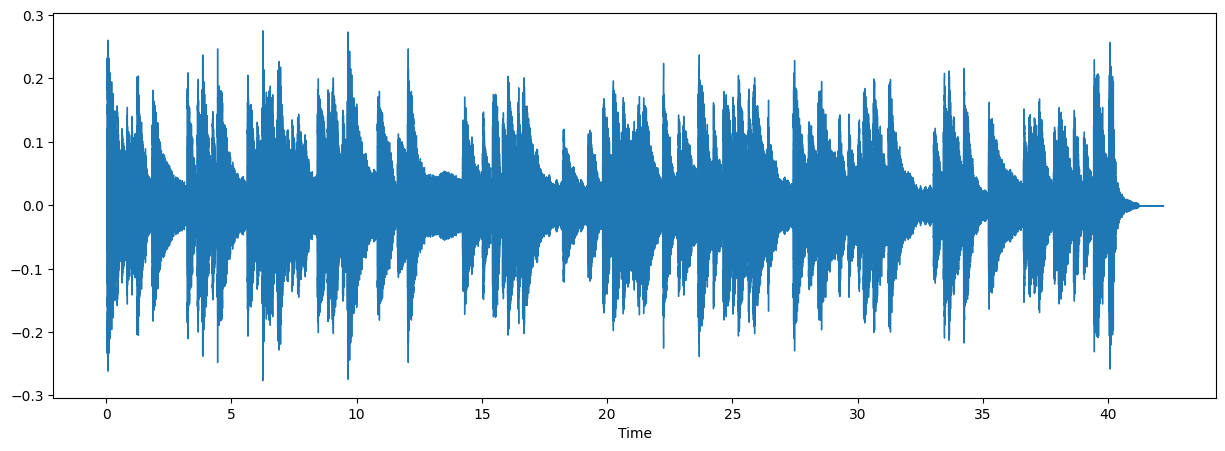

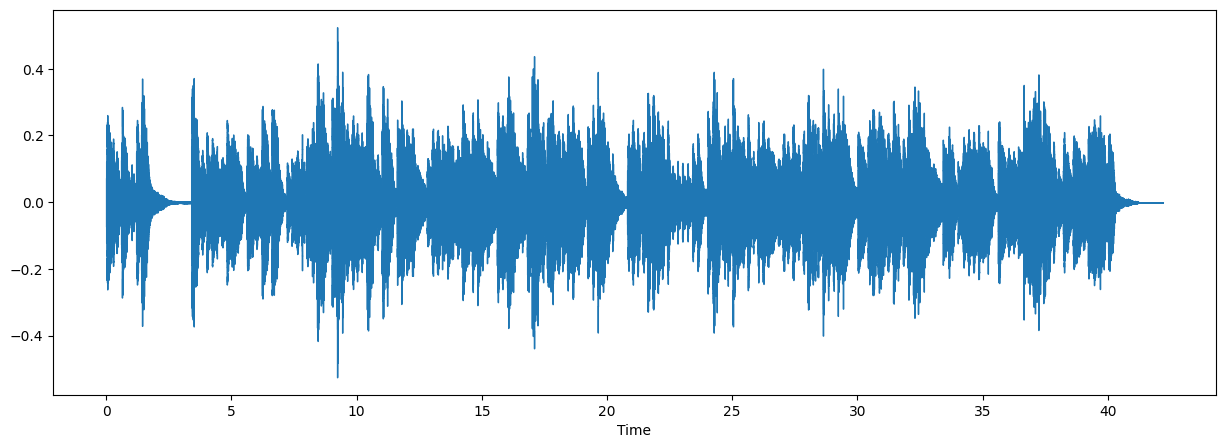

In [ ]:
#Time Domain
import numpy as np 
import matplotlib.pyplot as plt 
from glob import glob
import librosa as lr
import librosa.display
from IPython.display import Audio
import IPython.display as ipd

audio1='First'
y, sr = lr.load('original75.wav'.format(audio1))
ipd.Audio(y, rate=sr)
plt.figure(figsize=(15, 5))
lr.display.waveshow(y, sr=sr)
plt.show()

audio2='Second'
y, sr = lr.load('predicted75.wav'.format(audio2))
ipd.Audio(y, rate=sr)
plt.figure(figsize=(15, 5))
lr.display.waveshow(y, sr=sr)
plt.show()

In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# for data transformation
import numpy as np
# for visualizing the data
import matplotlib.pyplot as plt
# for opening the media file
import scipy.io.wavfile as wavfile

In [ ]:
Fs, aud = wavfile.read('predicted75.wav')
# select left channel only
aud = aud[:,0]
# trim the first 125 seconds
first = aud[:int(Fs*125)]

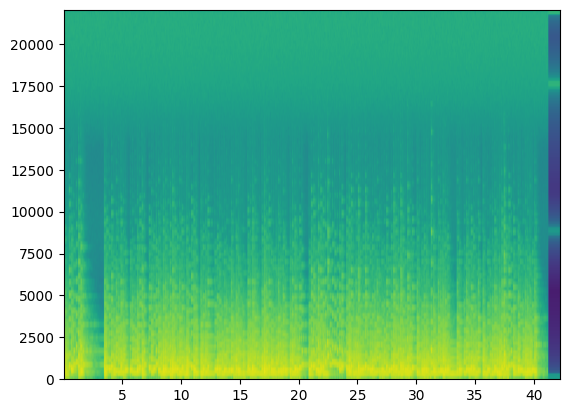

In [ ]:
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs)
plt.show()